In [47]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
import datetime

In [48]:
#import cleaned data set 
customerdf = pd.read_csv('Datasets/cleaned_customer.csv')
customerdf.head()

,Unnamed: 0,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,...,10,4,7,0,0,0,0,0,0,1
1,1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,...,1,2,5,0,0,0,0,0,0,0
2,2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,...,2,10,4,0,0,0,0,0,0,0
3,3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,...,0,4,6,0,0,0,0,0,0,0
4,4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,...,3,6,5,0,0,0,0,0,0,0


In [49]:
customerdf.columns

Index(['Unnamed: 0', 'ID', 'Year_Birth', 'Education', 'Marital_Status',
       'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response'],
      dtype='object')


In merging all data sets, we now have 28 columns of data, many of which can be used as predictor variables for our study. In this portion, we will be using Marital Status, Kidhome, and Teenhome to predict the types of product bought.

The predictor variables of choice in this portion will be:

1. **Marital_Status:** Customer's marital status

2. **Kidhome:** Number of children in customer's household

3. **Teenhome:** Number of teenagers in customer's household

Our belief is that the marital status and family composition of customers may influence their purchasing behavior, particularly in relation to the types of products bought. For instance, we believe that: 
-  Married individuals may prioritize wine purchases for social or special occasions.
- Single individuals might spend less on wine compared to married counterparts.

- Families with children and teenagers allocate budget towards fruits, meat, and fish to meet family dietary needs and preferences.
- Besides that, Teenagers may influence higher spending on sweets or snacks within households.

Overall, marital status and family composition can influence spending patterns on various product categories, reflecting differences in household priorities, preferences, and lifestyle choices. Analyzing these relationships can provide valuable insights into consumer behavior and help businesses tailor their marketing strategies and product offerings to different demographic segments

## Extracting Variables
##### We will start by analyzing the variables from the dataset (Marital Status, Kidhome, and Teenhome).


In [50]:
customerdf_predictor = pd.DataFrame(customerdf[['Marital_Status', 'Kidhome', 'Teenhome']])
customerdf_predictor

,Marital_Status,Kidhome,Teenhome
0,Single,0,0
1,Single,1,1
2,Together,0,0
3,Together,1,0
4,Married,1,0
...,...,...,...
2211,Married,0,1
2212,Together,2,1
2213,Divorced,0,0
2214,Together,0,1


In [51]:
customerdf_response = pd.DataFrame(customerdf[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']])
customerdf_response

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
0,635,88,546,172,88,88
1,11,1,6,2,1,6
2,426,49,127,111,21,42
3,11,4,20,10,3,5
4,173,43,118,46,27,15
...,...,...,...,...,...,...
2211,709,43,182,42,118,247
2212,406,0,30,0,0,8
2213,908,48,217,32,12,24
2214,428,30,214,80,30,61


In [52]:
customerdf_joint = customerdf.loc[:, ['Marital_Status', 'Kidhome', 'Teenhome','MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds','Dt_Customer', 'Recency']]
customerdf_joint

,Marital_Status,Kidhome,Teenhome,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,Dt_Customer,Recency
0,Single,0,0,635,88,546,172,88,88,04-09-2012,58
1,Single,1,1,11,1,6,2,1,6,08-03-2014,38
2,Together,0,0,426,49,127,111,21,42,21-08-2013,26
3,Together,1,0,11,4,20,10,3,5,10-02-2014,26
4,Married,1,0,173,43,118,46,27,15,19-01-2014,94
...,...,...,...,...,...,...,...,...,...,...,...
2211,Married,0,1,709,43,182,42,118,247,13-06-2013,46
2212,Together,2,1,406,0,30,0,0,8,10-06-2014,56
2213,Divorced,0,0,908,48,217,32,12,24,25-01-2014,91
2214,Together,0,1,428,30,214,80,30,61,24-01-2014,8


In [53]:
customerdf_joint['Dt_Customer'] = pd.to_datetime(customerdf_joint['Dt_Customer'], format='%d-%m-%Y')
customerdf_joint['CurrentDate'] = datetime.datetime(2021, 1, 1)
customerdf_joint['numMonths'] = ((customerdf_joint['CurrentDate'] - customerdf_joint['Dt_Customer'])/np.timedelta64(1, 'M'))
customerdf_joint['Recency'] = customerdf_joint['Recency']/30 #assume 30days in a month

In [54]:
#average purchases over the months
for var in customerdf_joint.columns[1:9]:
    customerdf_joint[var] = customerdf_joint[var]/ customerdf_joint["numMonths"]

customerdf_joint.drop(columns = ['Dt_Customer', 'CurrentDate', "numMonths", "Recency"], inplace = True)

In [55]:
customerdf_joint

,Marital_Status,Kidhome,Teenhome,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds
0,Single,0.000000,0.000000,6.473200,0.897073,5.565932,1.753371,0.897073,0.897073
1,Single,0.012445,0.012445,0.136893,0.012445,0.074669,0.024890,0.012445,0.074669
2,Together,0.000000,0.000000,4.909294,0.564684,1.463569,1.279182,0.242007,0.484015
3,Together,0.012316,0.000000,0.135479,0.049265,0.246325,0.123162,0.036949,0.061581
4,Married,0.012210,0.000000,2.112249,0.525010,1.440725,0.561638,0.329657,0.183143
...,...,...,...,...,...,...,...,...,...
2211,Married,0.000000,0.011236,7.966292,0.483146,2.044944,0.471910,1.325843,2.775281
2212,Together,0.025866,0.012933,5.250730,0.000000,0.387985,0.000000,0.000000,0.103463
2213,Divorced,0.000000,0.000000,11.112515,0.587446,2.655744,0.391630,0.146861,0.293723
2214,Together,0.000000,0.012234,5.235991,0.367009,2.617995,0.978690,0.367009,0.746251


## Multi-Variate Analysis 
### Explore the distribution of the predictor and response vairables through boxplot and histogram

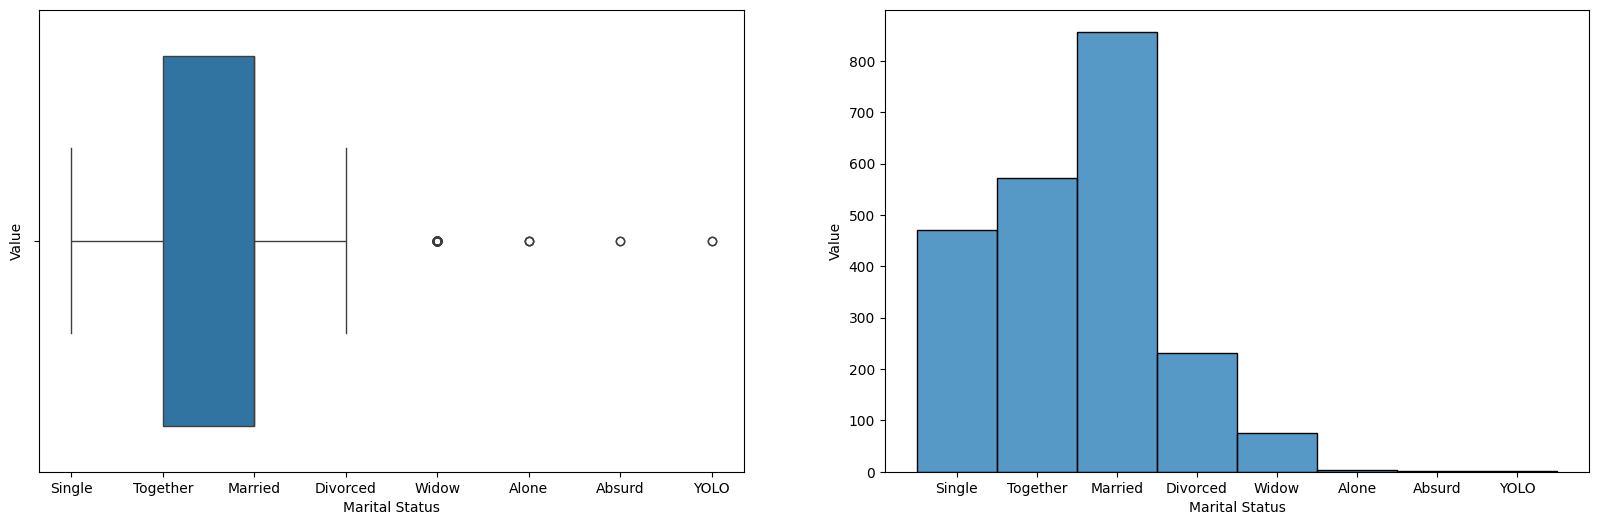

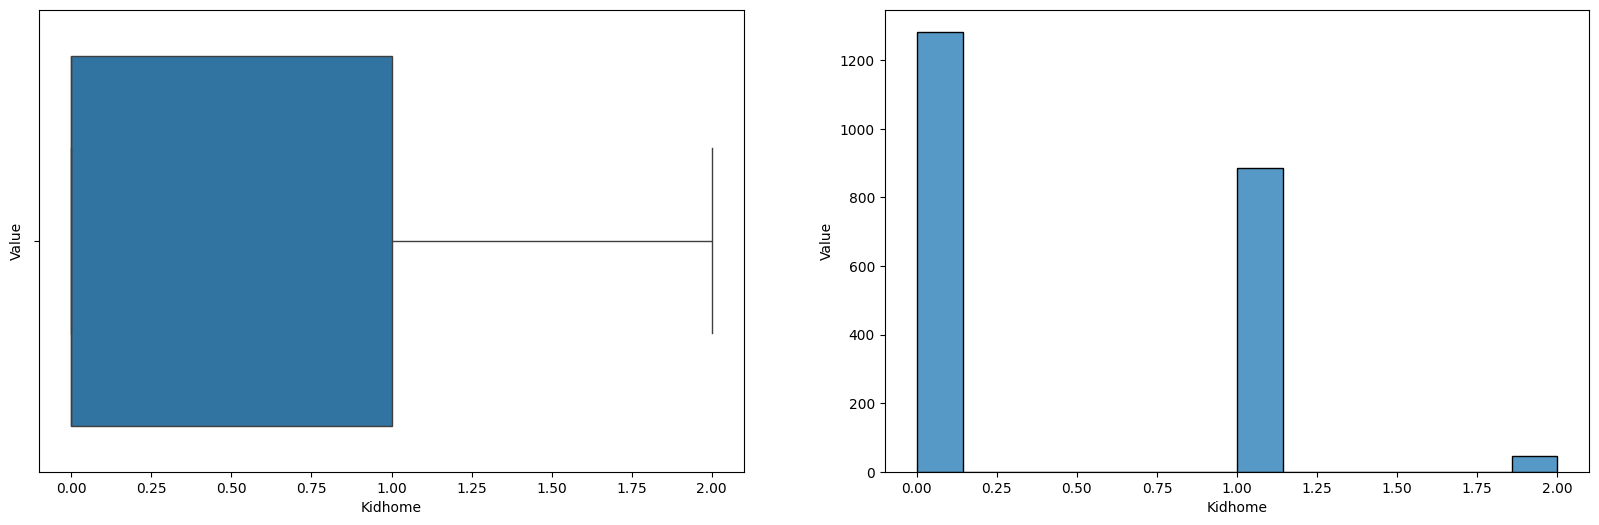

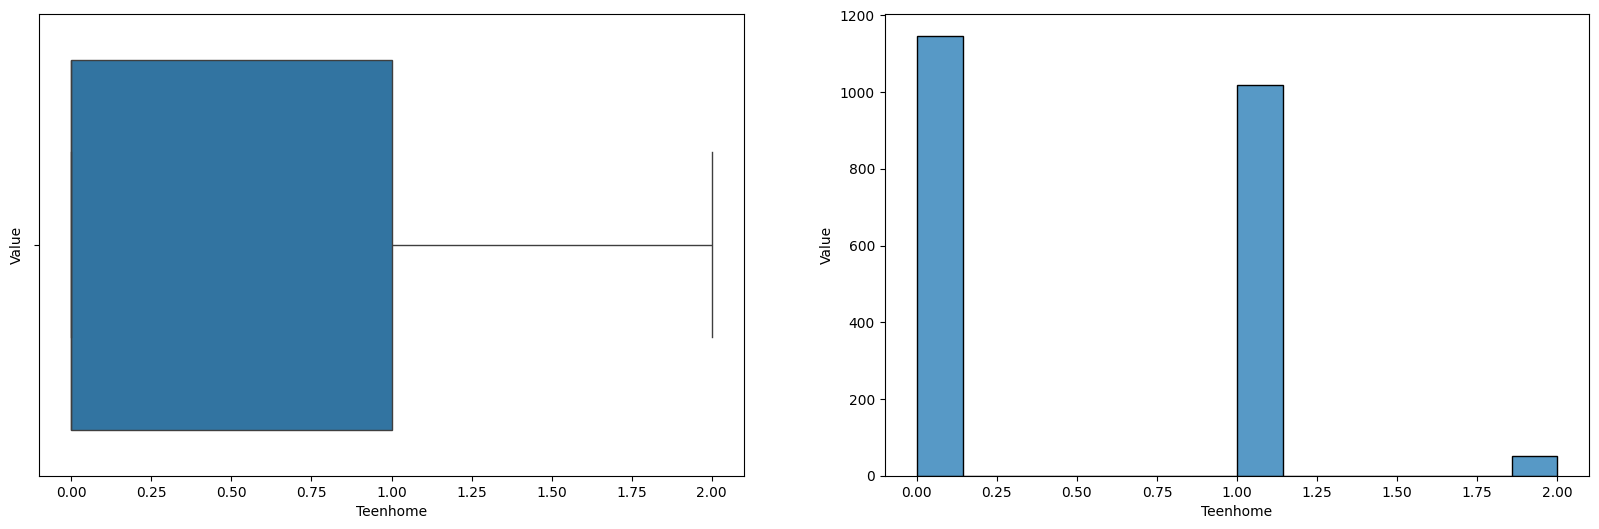

In [56]:
import seaborn as sb
import matplotlib.pyplot as plt

# Draw the distributions of all variables

# Martial Status distribution
f, axes = plt.subplots(1, 2, figsize=(20, 6))
sb.boxplot(data=customerdf_predictor['Marital_Status'], orient="h", ax=axes[0])
sb.histplot(data=customerdf_predictor['Marital_Status'], ax=axes[1])
for i in range(2):
    axes[i].set_xlabel('Marital Status')
    axes[i].set_ylabel('Value')

# Kidhome distribution
f, axes = plt.subplots(1, 2, figsize=(20, 6))
sb.boxplot(data=customerdf_predictor['Kidhome'], orient="h", ax=axes[0])
sb.histplot(data=customerdf_predictor['Kidhome'], ax=axes[1])
for i in range(2):
    axes[i].set_xlabel('Kidhome')
    axes[i].set_ylabel('Value')

# Teenhome distribution
f, axes = plt.subplots(1, 2, figsize=(20, 6))
sb.boxplot(data=customerdf_predictor['Teenhome'], orient="h", ax=axes[0])
sb.histplot(data=customerdf_predictor['Teenhome'], ax=axes[1])
for i in range(2):
    axes[i].set_xlabel('Teenhome')
    axes[i].set_ylabel('Value')

plt.show()


As we can observe, the marjority individuals are married with no kids and teens. 

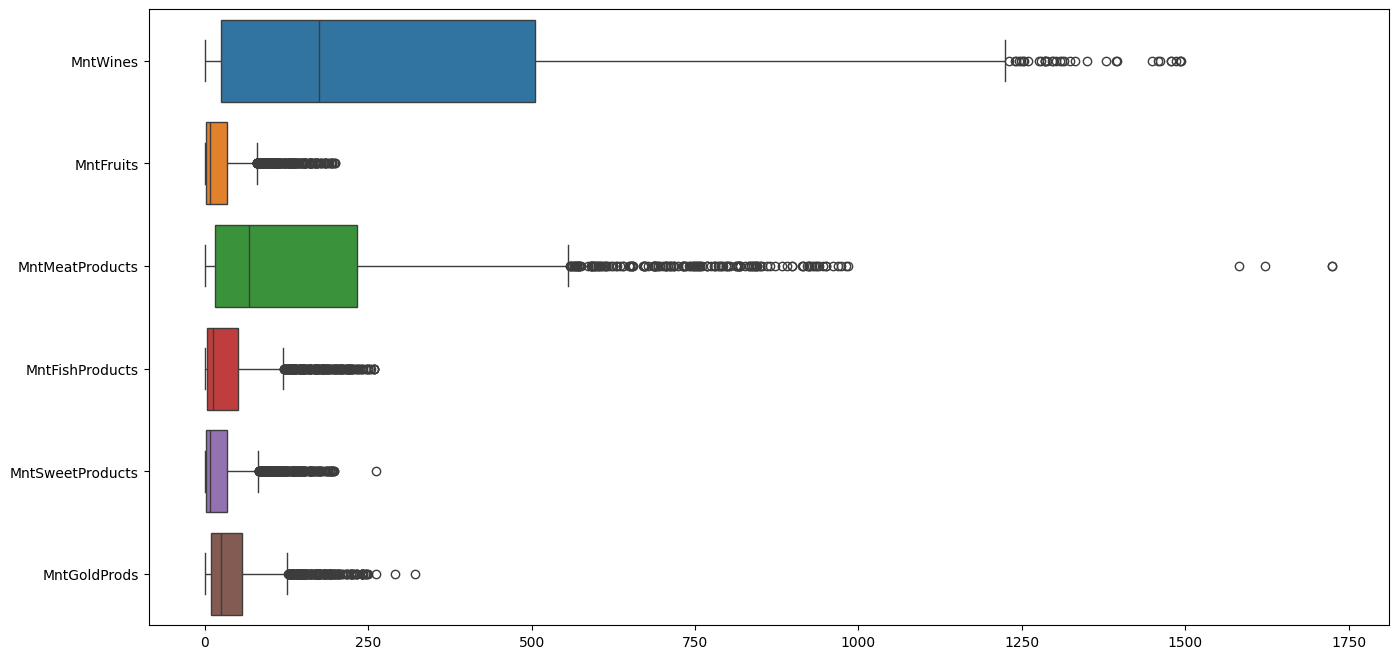

In [57]:
# Draw the Boxplots of response variables
plt.figure(figsize=(16, 8))
sb.boxplot(data=customerdf_response, orient="h")
plt.show()


The most product bought by the customer is wine, followed by meat. 

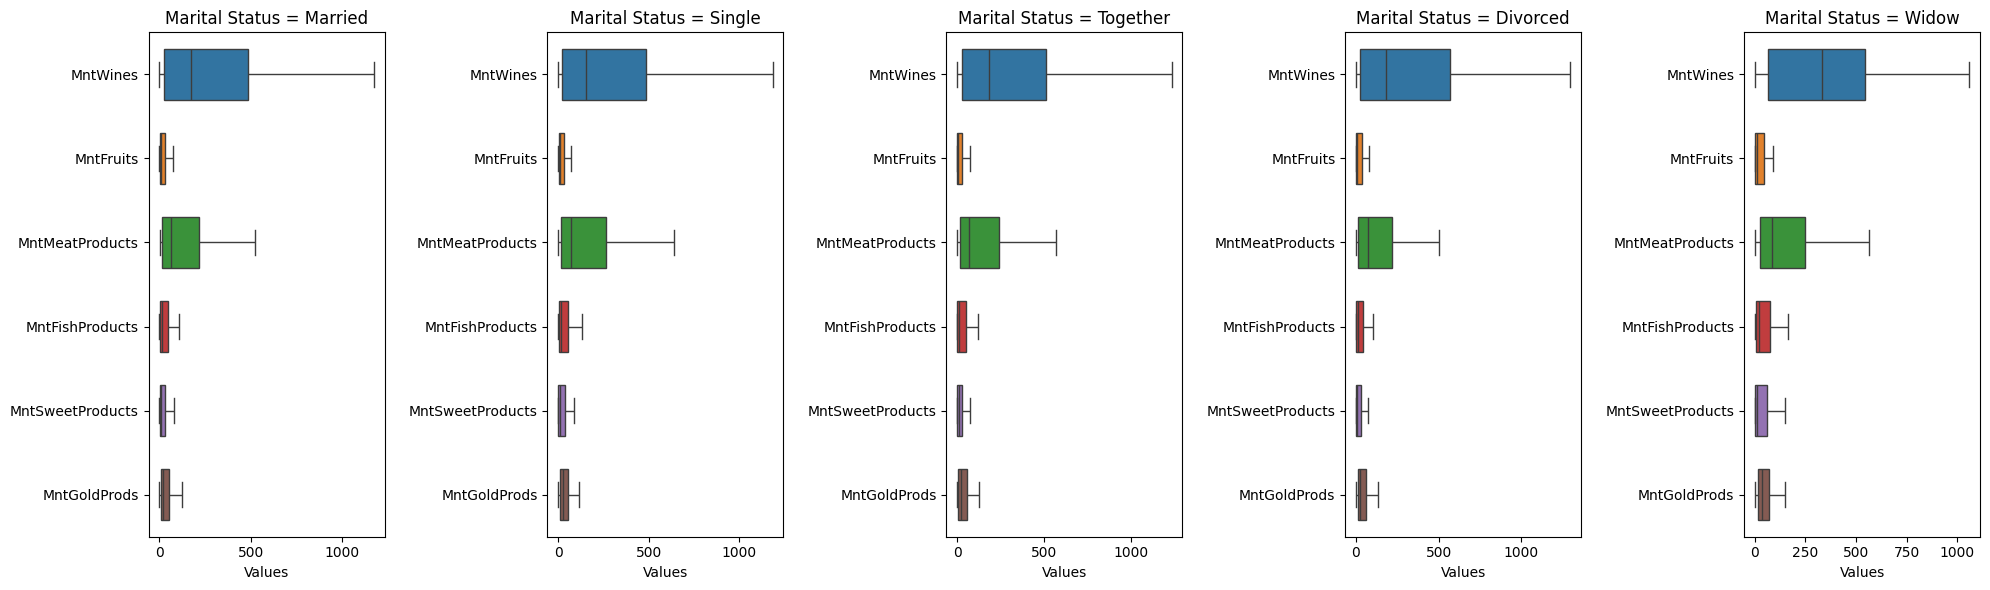

In [ ]:
# Generate some example data for demonstration
np.random.seed(0)
X = customerdf_predictor['Marital_Status']  # Example predictor variable
Y = np.array(customerdf_response)  # Example response variables

# Define marital statuses
marital_statuses = ['Married', 'Single', 'Together', 'Divorced', 'Widow']

# Create boxplots for each combination of marital status and type of product
plt.figure(figsize=(20, 6))

for i, status in enumerate(marital_statuses):
    plt.subplot(1, len(marital_statuses), i + 1)
    data = [Y[X == status][:, j] for j in range(Y.shape[1])]
    sb.boxplot(data=data, width=0.6, showfliers=False, orient='h')
    plt.yticks(range(Y.shape[1]), customerdf_response.columns)
    plt.xlabel('Values')
    plt.title(f'Marital Status = {status}')

plt.tight_layout()
plt.show()


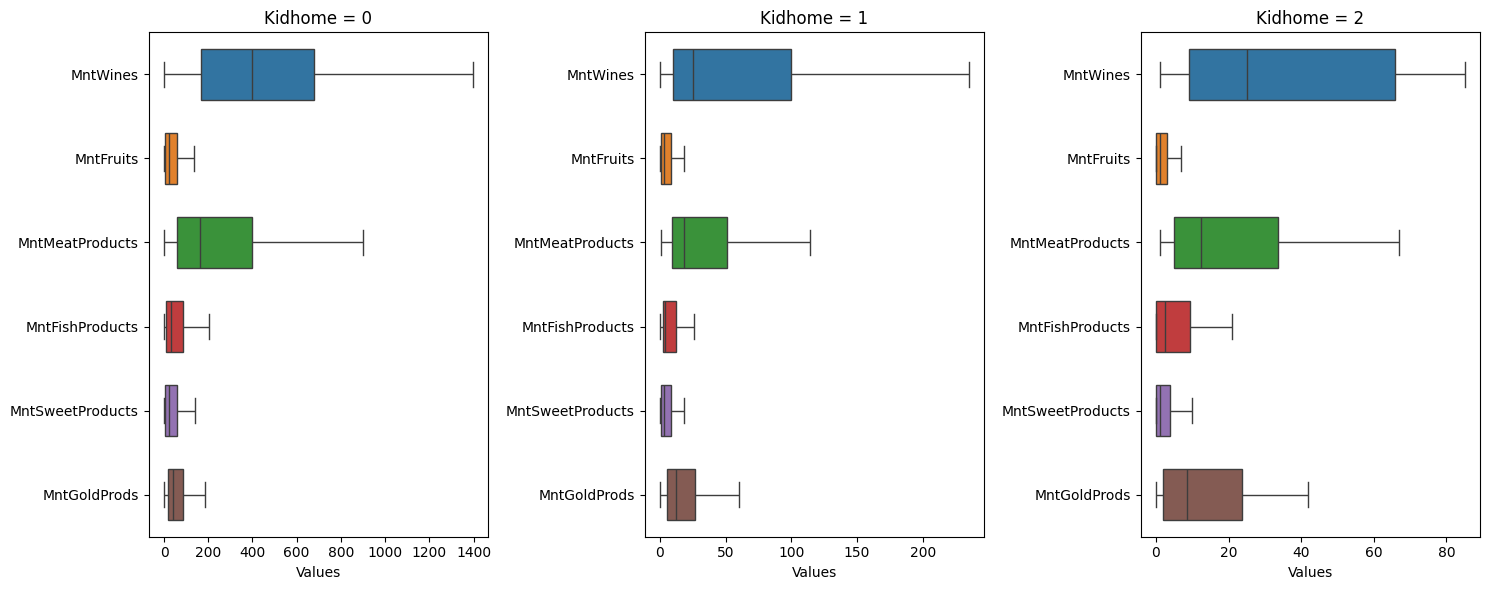

In [ ]:
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt

# Generate some example data for demonstration
np.random.seed(0)
X = customerdf_predictor['Kidhome']  # Example predictor variable
Y = np.array(customerdf_response)  # Example response variables

# Create boxplots for each combination of Kidhome value and type of product
plt.figure(figsize=(15, 6))

# Iterate over different Kidhome values
for i, kidhome_value in enumerate(sorted(X.unique())):
    plt.subplot(1, 3, i + 1)
    data = [Y[X == kidhome_value][:, j] for j in range(Y.shape[1])]
    sb.boxplot(data=data, width=0.6, showfliers=False, orient='h')
    plt.yticks(range(Y.shape[1]), customerdf_response.columns)
    plt.xlabel('Values')
    plt.title(f'Kidhome = {kidhome_value}')

plt.tight_layout()
plt.show()


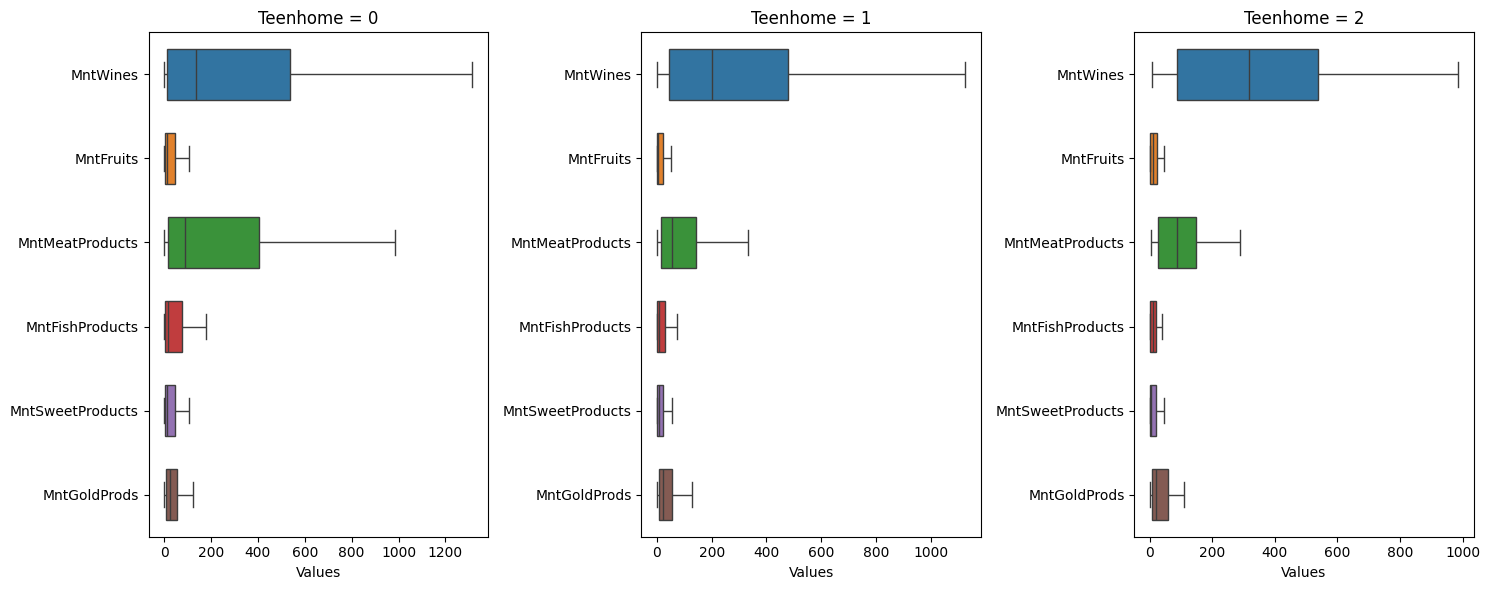

In [ ]:
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt

# Generate some example data for demonstration
np.random.seed(0)
X = customerdf_predictor['Teenhome']  # Example predictor variable
Y = np.array(customerdf_response)  # Example response variables

# Create boxplots for each combination of Teenhome value and type of product
plt.figure(figsize=(15, 6))

# Iterate over different Teenhome values
for i, teenhome_value in enumerate(sorted(X.unique())):
    plt.subplot(1, 3, i + 1)
    data = [Y[X == teenhome_value][:, j] for j in range(Y.shape[1])]
    sb.boxplot(data=data, width=0.6, showfliers=False, orient='h')
    plt.yticks(range(Y.shape[1]), customerdf_response.columns)
    plt.xlabel('Values')
    plt.title(f'Teenhome = {teenhome_value}')

plt.tight_layout()
plt.show()


## Jointplot
It will be more interesting to visualize them together in a jointplot as it tells us something about the correlation between the three variables

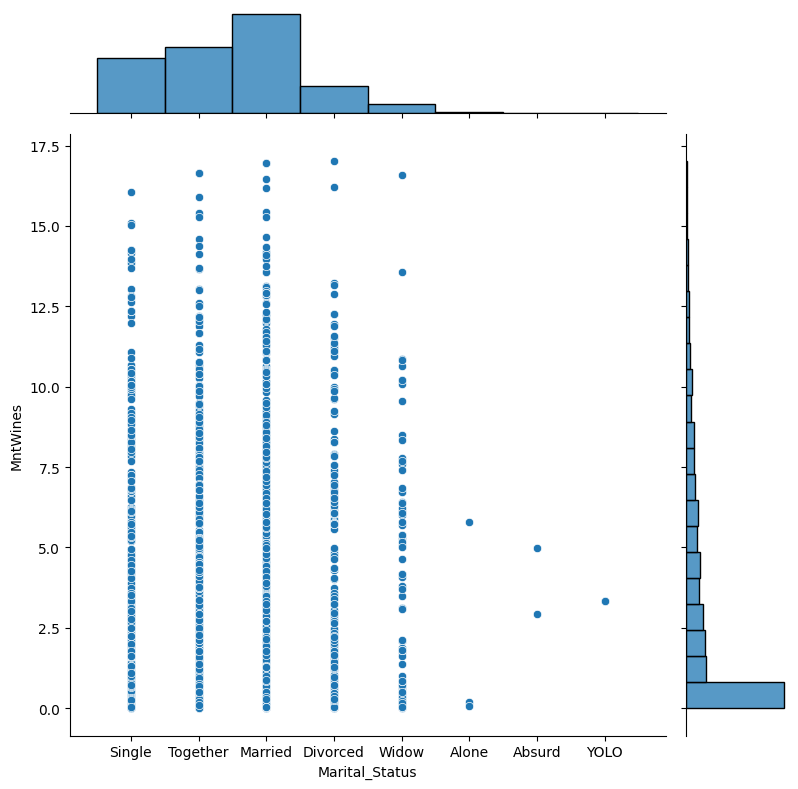

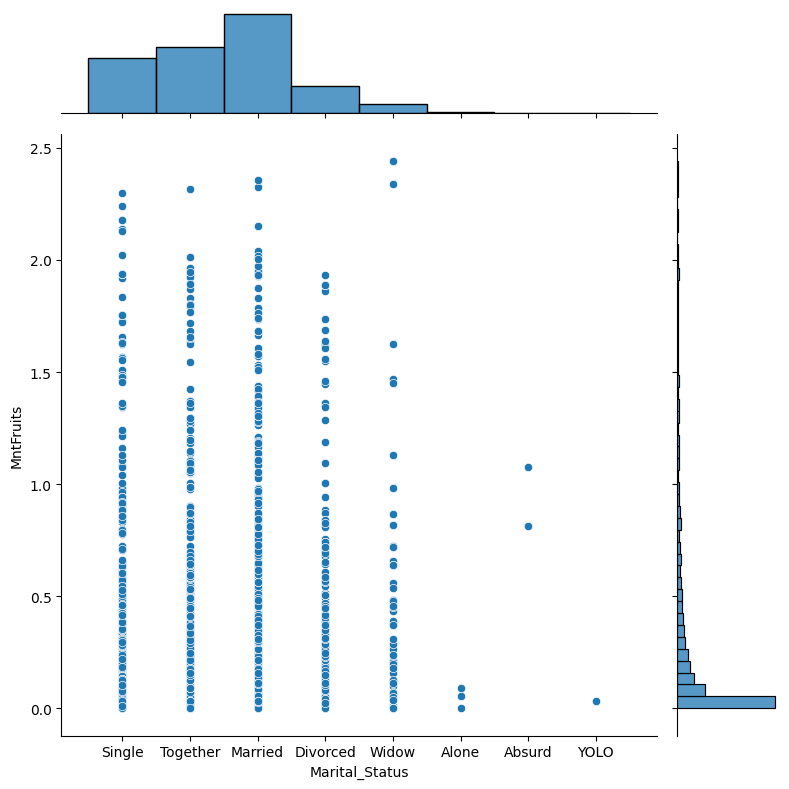

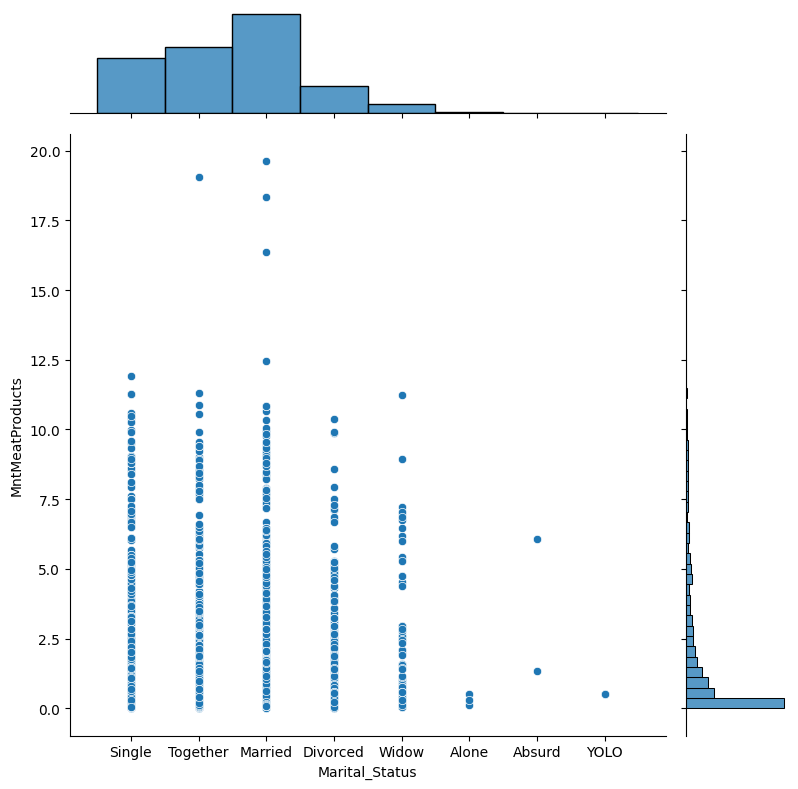

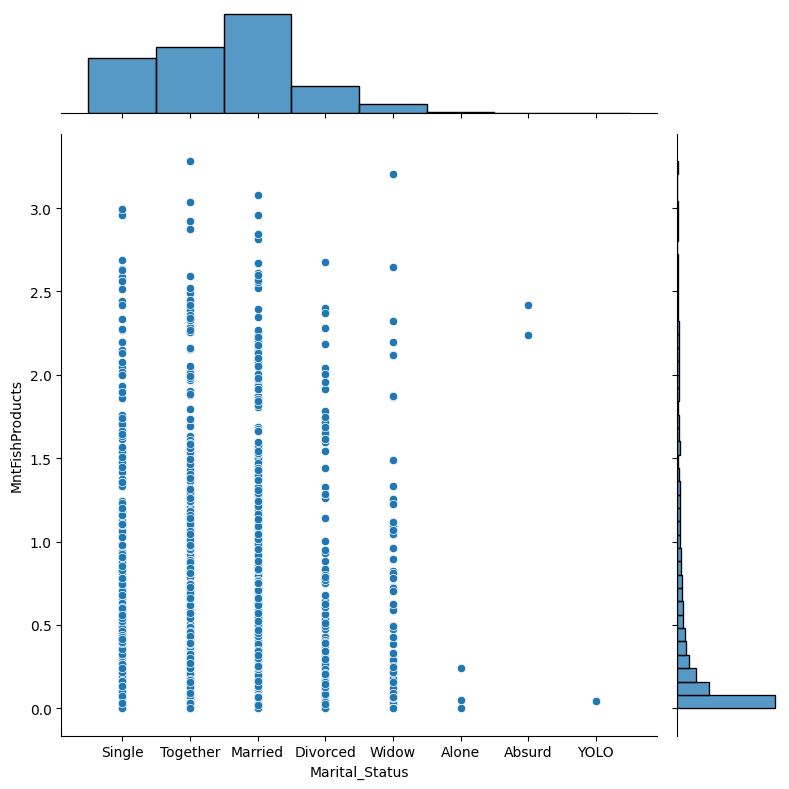

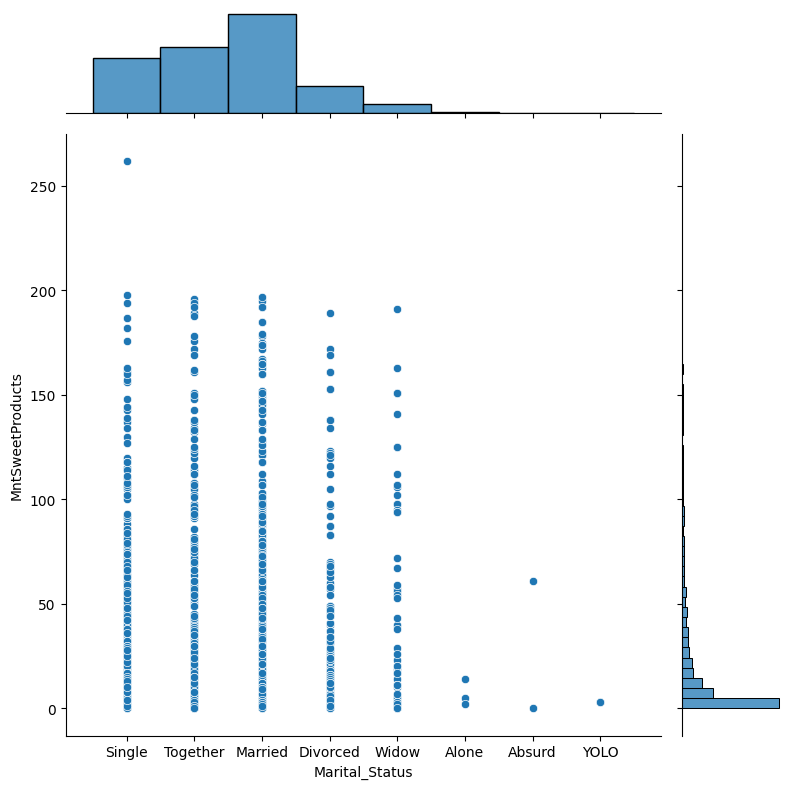

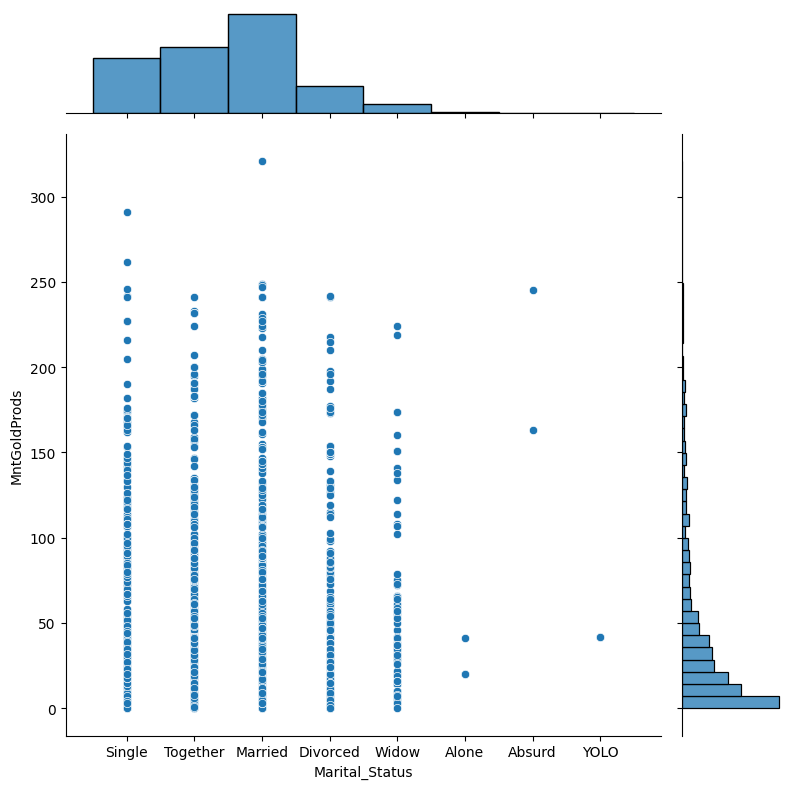

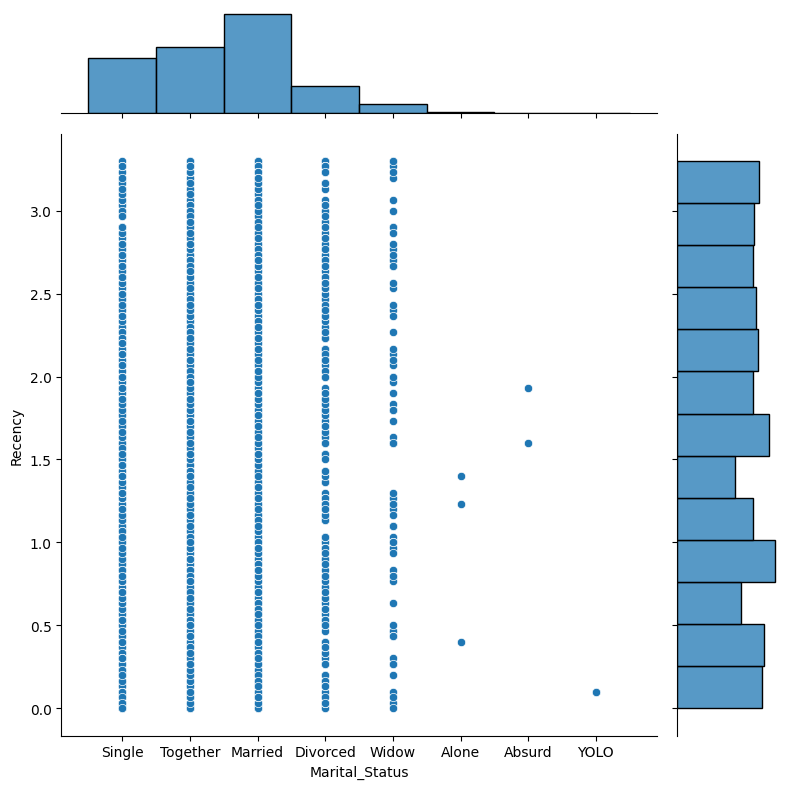

In [ ]:
import seaborn as sb

variables_to_exclude = ["Marital_Status", "Kidhome", "Teenhome"]

# Filter response variables
response_vars = [var for var in customerdf_joint.columns if var not in variables_to_exclude]

# Plot response variables against Marital_Status
for var in response_vars:
    sb.jointplot(data=customerdf_joint, x="Marital_Status", y=var, height=8)


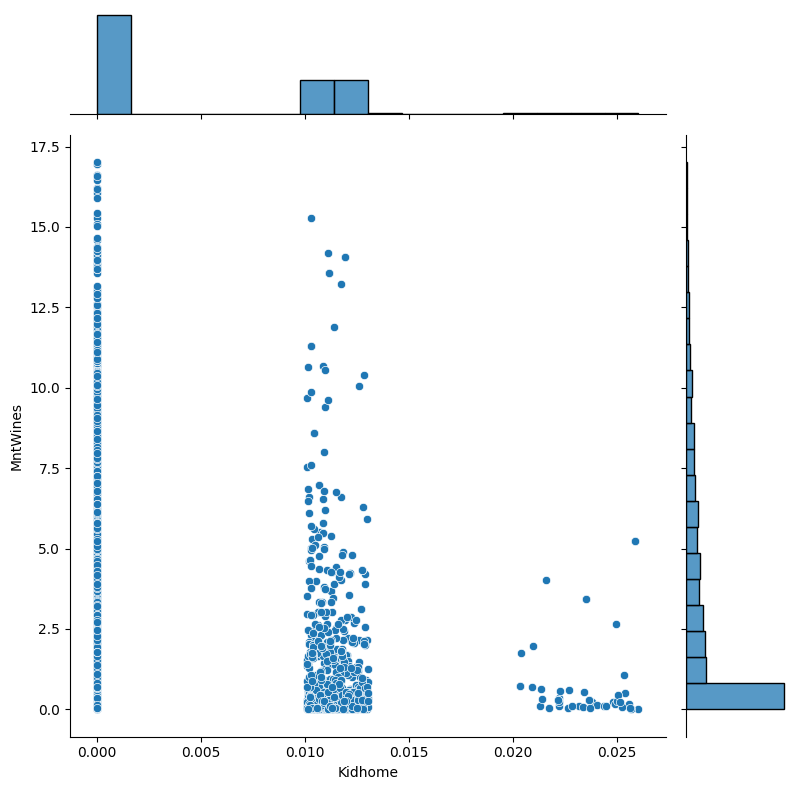

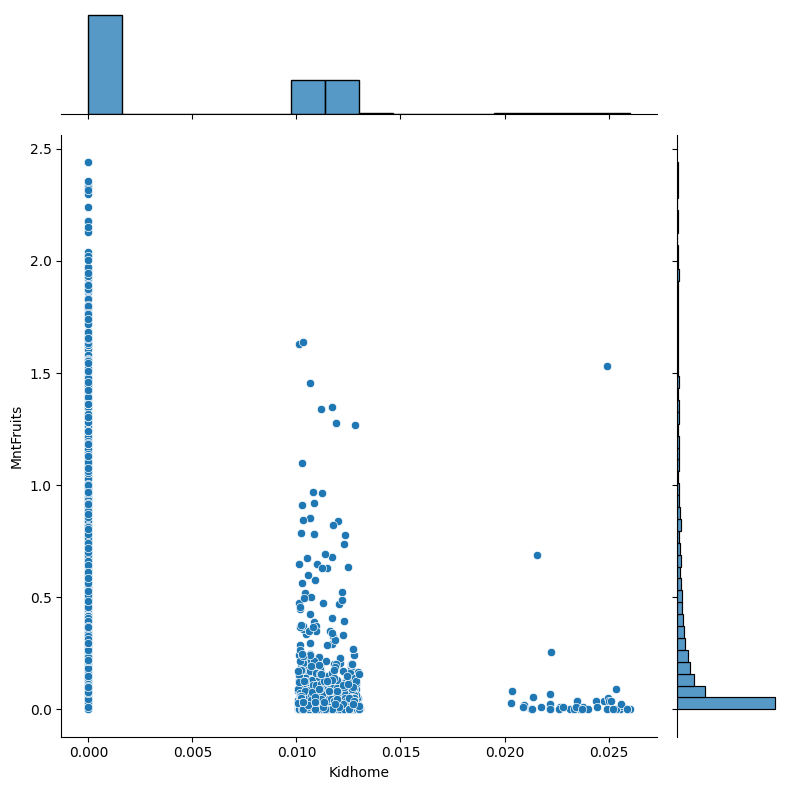

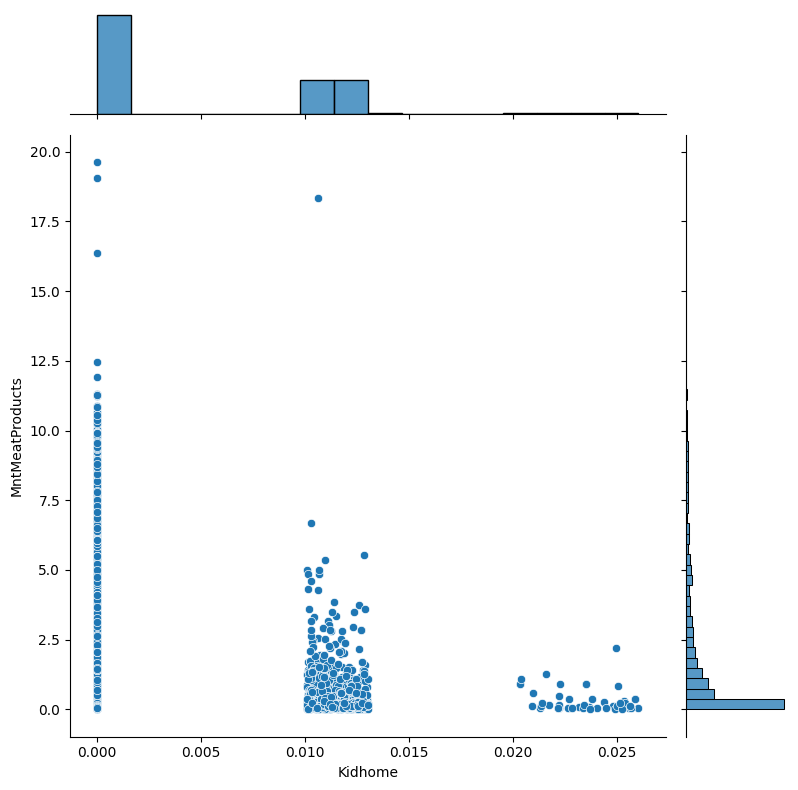

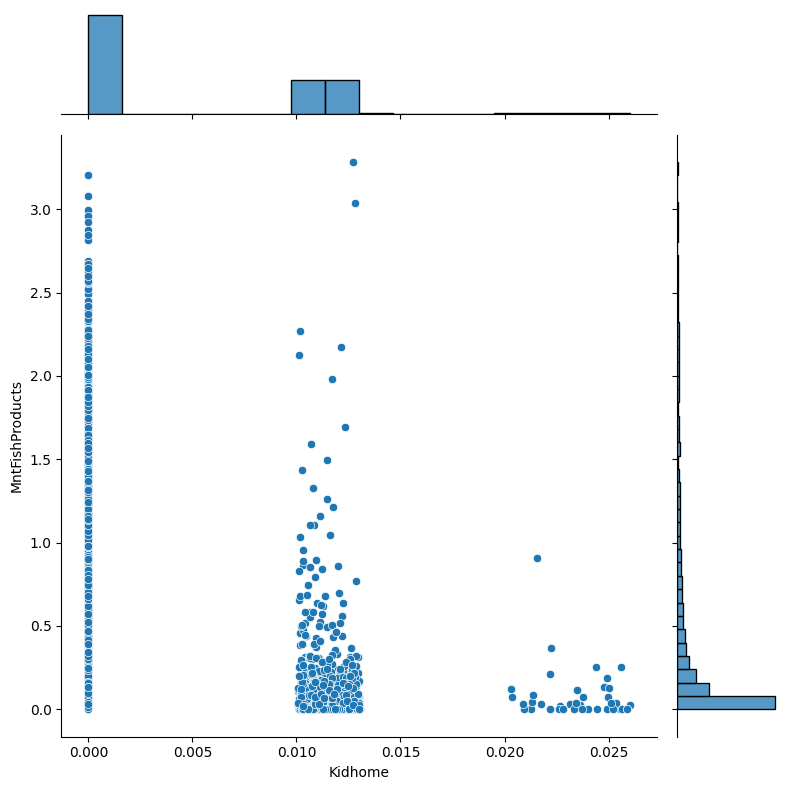

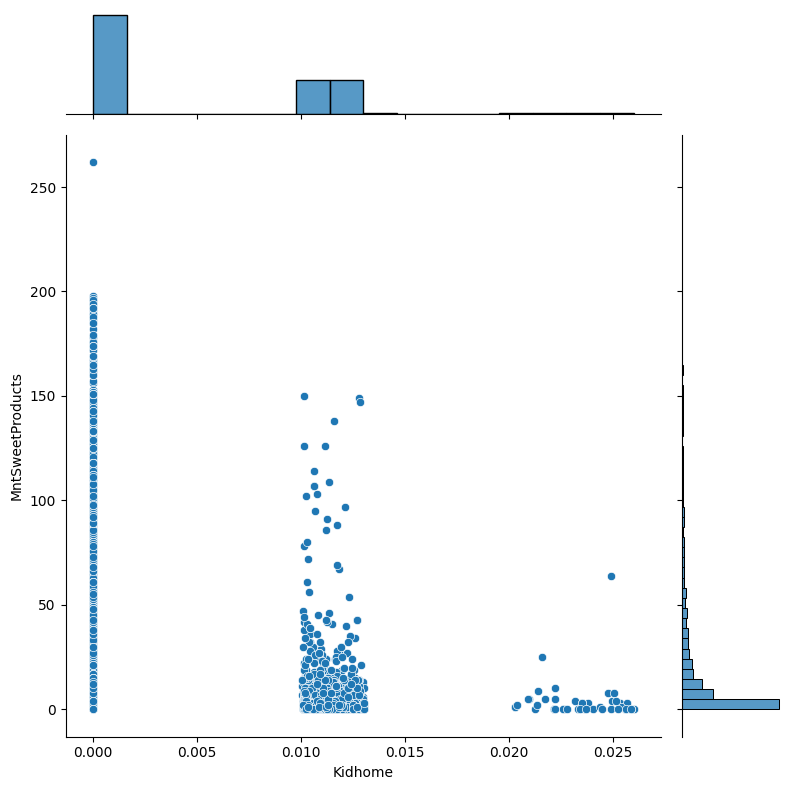

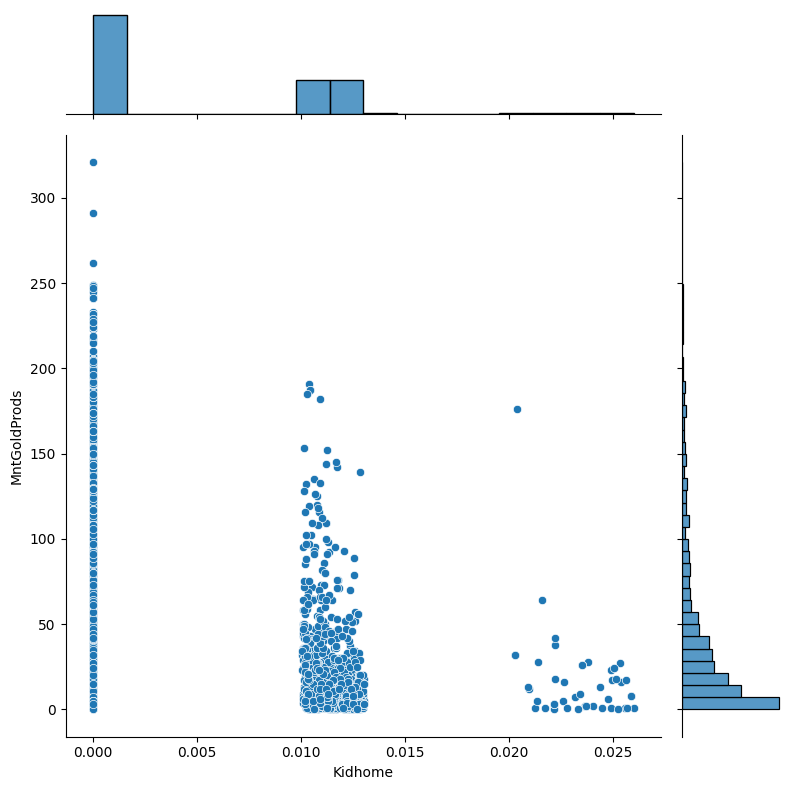

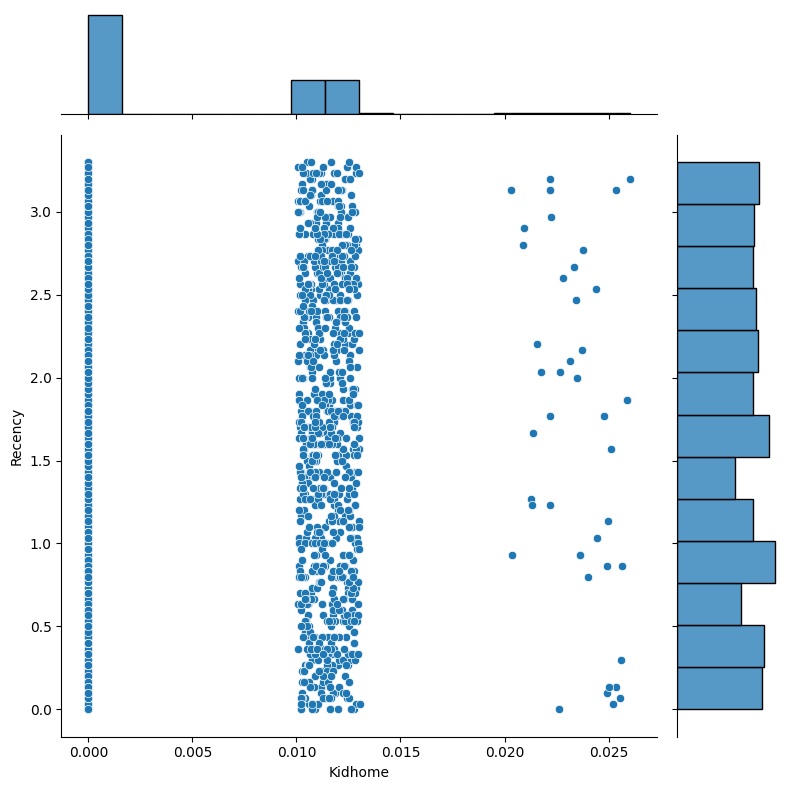

In [ ]:
import seaborn as sb

variables_to_exclude = ["Marital_Status", "Kidhome", "Teenhome"]

# Filter response variables
response_vars = [var for var in customerdf_joint.columns if var not in variables_to_exclude]

# Plot response variables against Kidhome
for var in response_vars:
    sb.jointplot(data=customerdf_joint, x="Kidhome", y=var, height=8)


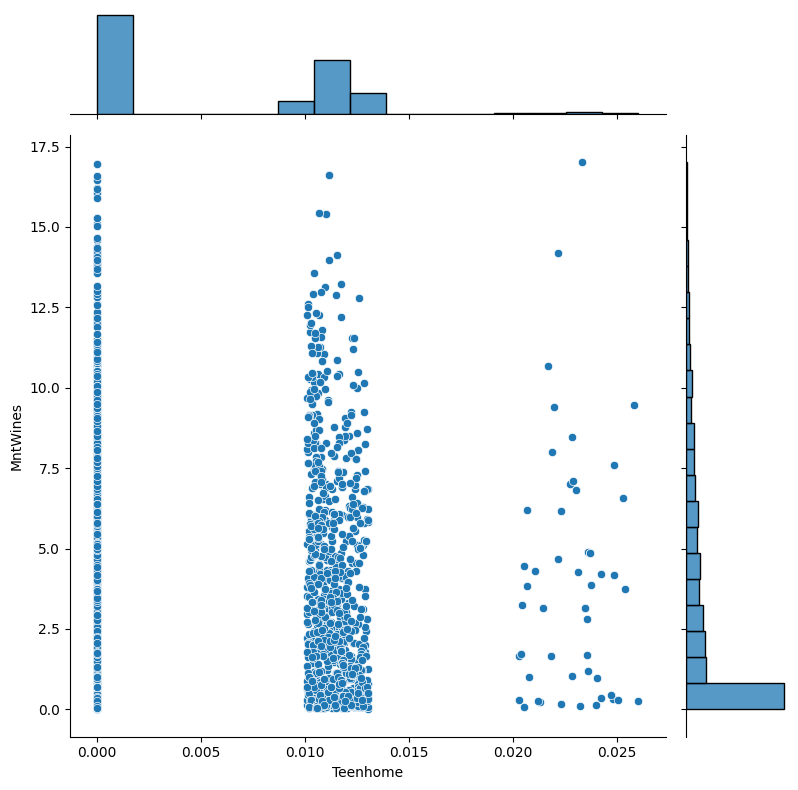

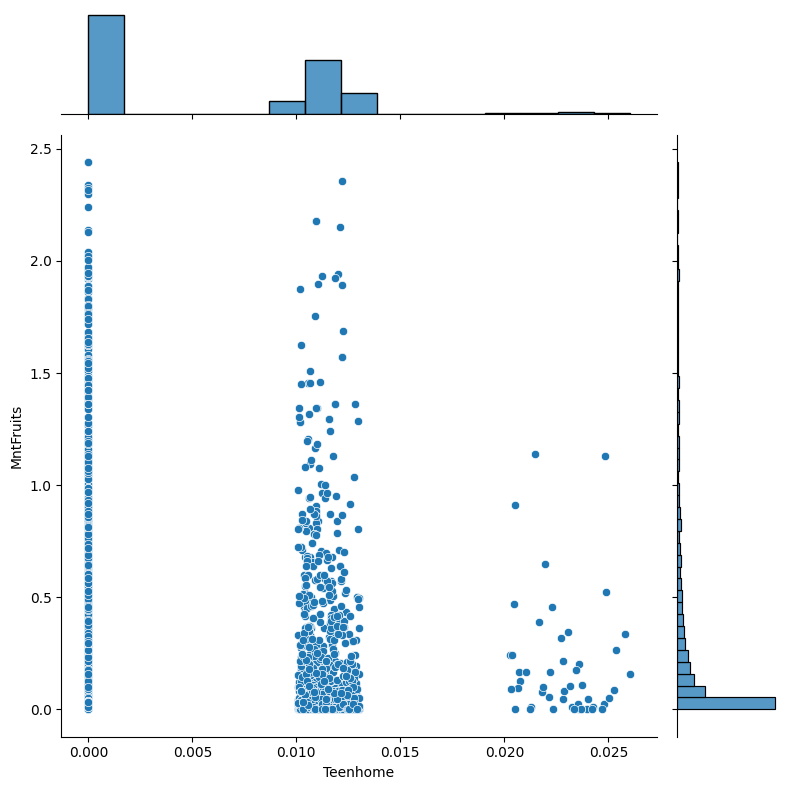

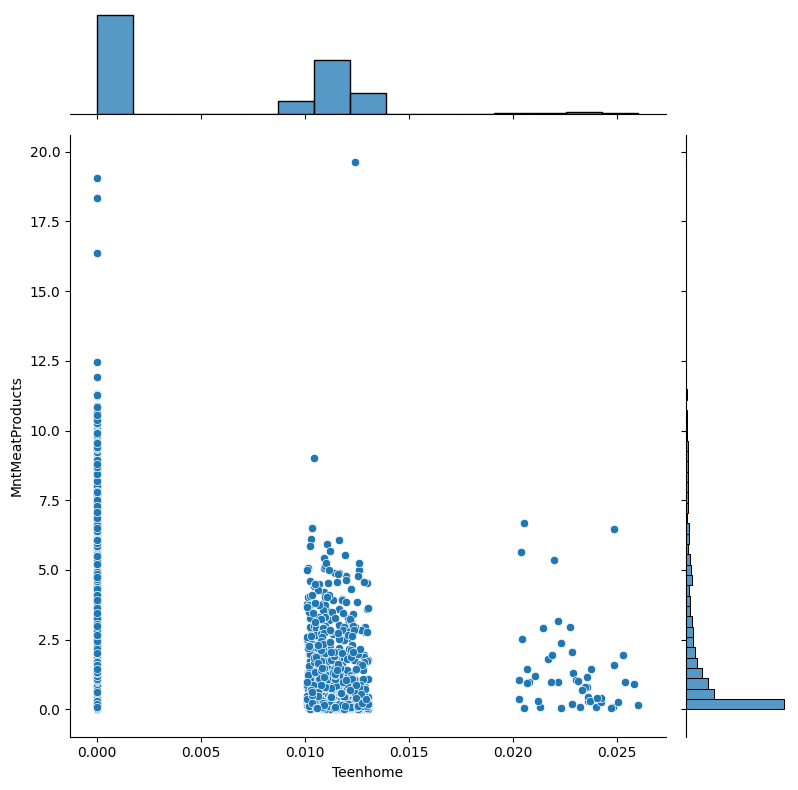

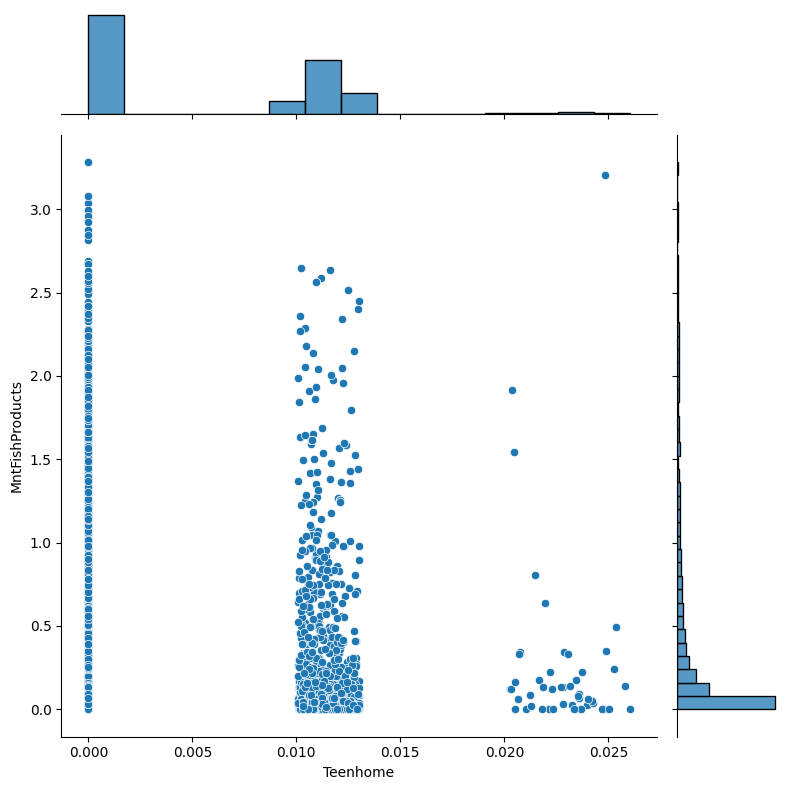

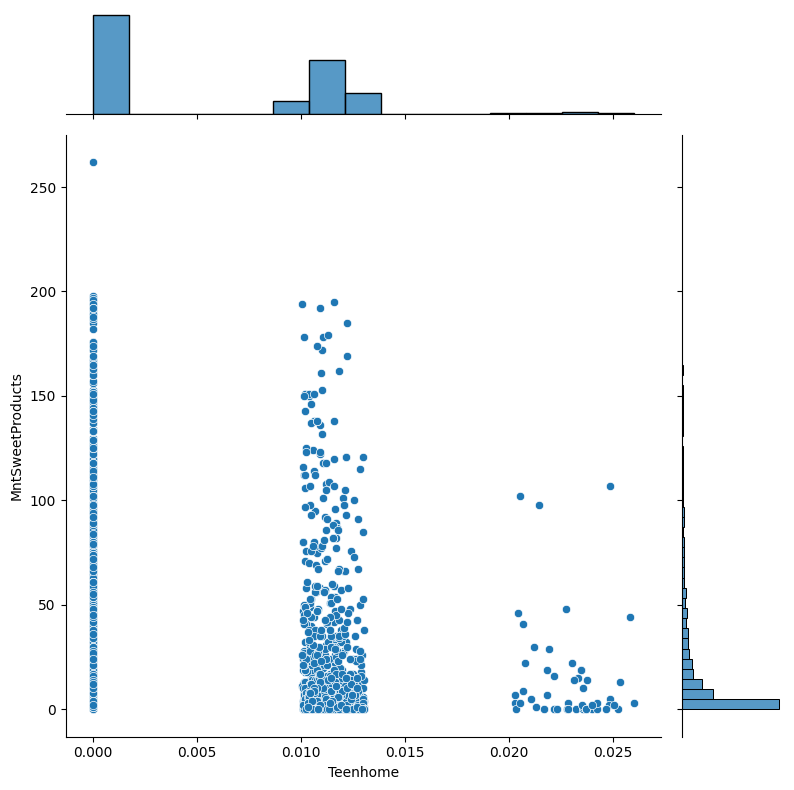

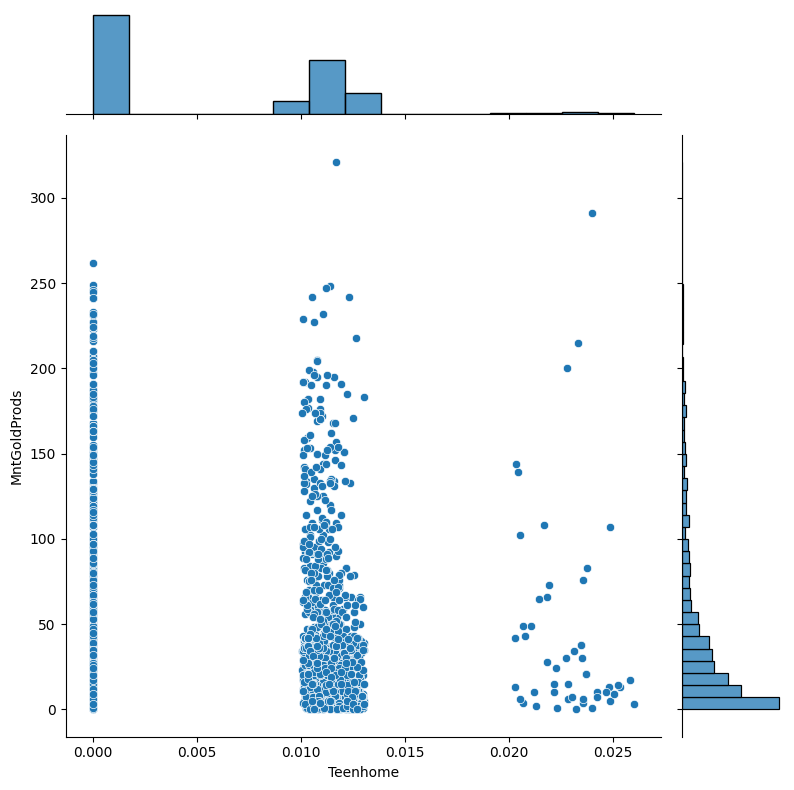

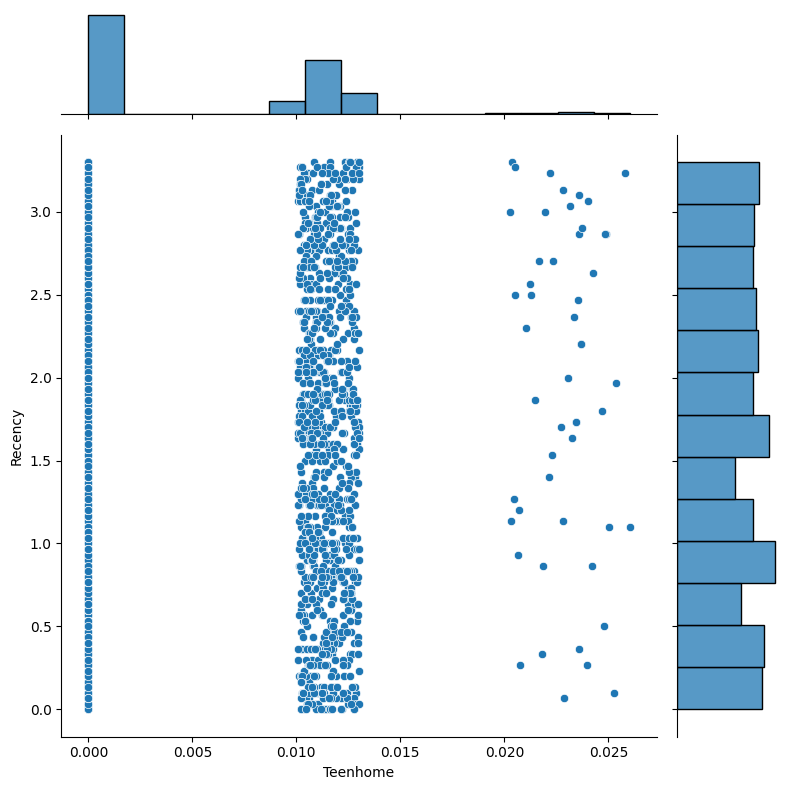

In [ ]:
import seaborn as sb

variables_to_exclude = ["Marital_Status", "Kidhome", "Teenhome"]

# Filter response variables
response_vars = [var for var in customerdf_joint.columns if var not in variables_to_exclude]

# Plot response variables against Teenhome
for var in response_vars:
    sb.jointplot(data=customerdf_joint, x="Teenhome", y=var, height=8)


## Correlation matrix 

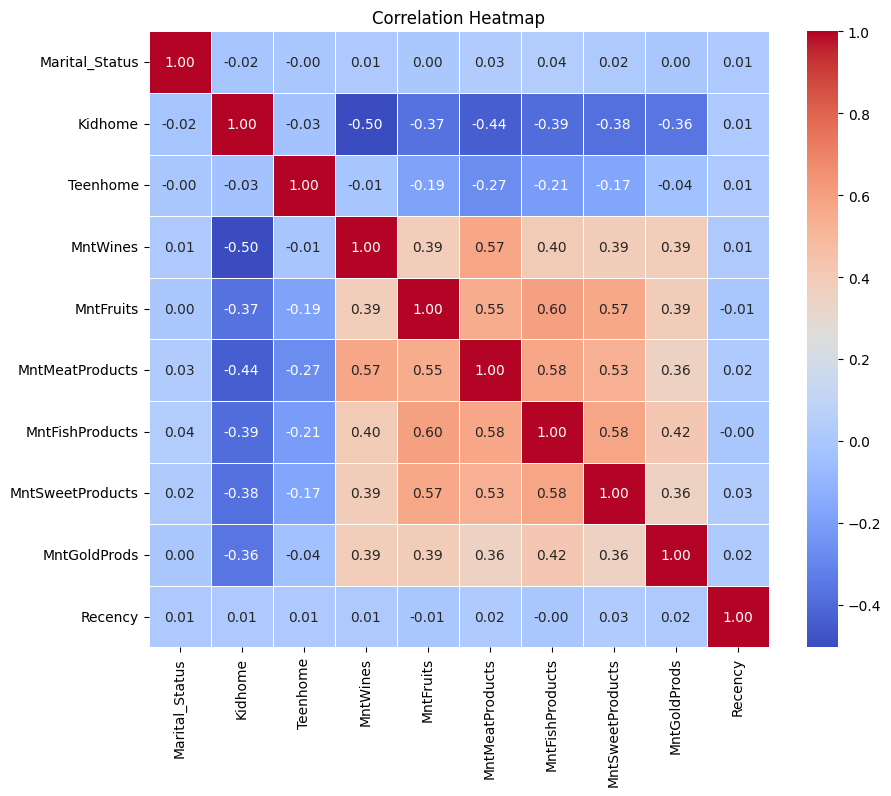

In [ ]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

# Assuming customerdf_joint is your DataFrame
df = pd.DataFrame(customerdf_joint)

# Encode categorical variables
df['Marital_Status'] = df['Marital_Status'].astype('category')
df['Marital_Status'] = df['Marital_Status'].cat.codes

# Compute the correlation matrix
corr_matrix = df.corr()

# create the heatmap
plt.figure(figsize=(10, 8))
sb.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


## Observation 
There is a fairly good correlation between the number of kids and the amount of wines bought which has a value of -0.50. Thus, as the number of kids at home increases, the amount spent on wines tends to decrease. This shows that having kids play an important factor in purchasing wines. However, the number of teens does not seem to have a correlation. 



# Multi-variate K-means clustering

In [ ]:
# convert the categorical variables to numerical values
customerdf_numeric = pd.DataFrame(customerdf_joint)

# Encode Marital Status to Numerical Values
label_encoder = LabelEncoder()
customerdf_numeric['MaritalStatusEncoded'] = label_encoder.fit_transform(customerdf_numeric['Marital_Status'])

# Drop the original categorical Marital Status column
customerdf_numeric.drop('Marital_Status', axis=1, inplace=True)

# Display
customerdf_numeric

,Kidhome,Teenhome,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,Recency,MaritalStatusEncoded
0,0.000000,0.000000,6.473200,0.897073,5.565932,1.753371,88,88,1.933333,4
1,0.012445,0.012445,0.136893,0.012445,0.074669,0.024890,1,6,1.266667,4
2,0.000000,0.000000,4.909294,0.564684,1.463569,1.279182,21,42,0.866667,5
3,0.012316,0.000000,0.135479,0.049265,0.246325,0.123162,3,5,0.866667,5
4,0.012210,0.000000,2.112249,0.525010,1.440725,0.561638,27,15,3.133333,3
...,...,...,...,...,...,...,...,...,...,...
2211,0.000000,0.011236,7.966292,0.483146,2.044944,0.471910,118,247,1.533333,3
2212,0.025866,0.012933,5.250730,0.000000,0.387985,0.000000,0,8,1.866667,5
2213,0.000000,0.000000,11.112515,0.587446,2.655744,0.391630,12,24,3.033333,2
2214,0.000000,0.012234,5.235991,0.367009,2.617995,0.978690,30,61,0.266667,5


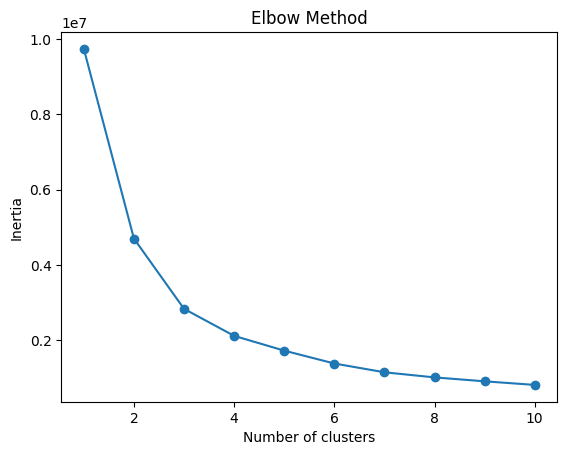

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculate inertia for different number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='random', random_state=42)
    kmeans.fit(customerdf_numeric)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


optimal number of clusters (k) = 3 using the elbow method 

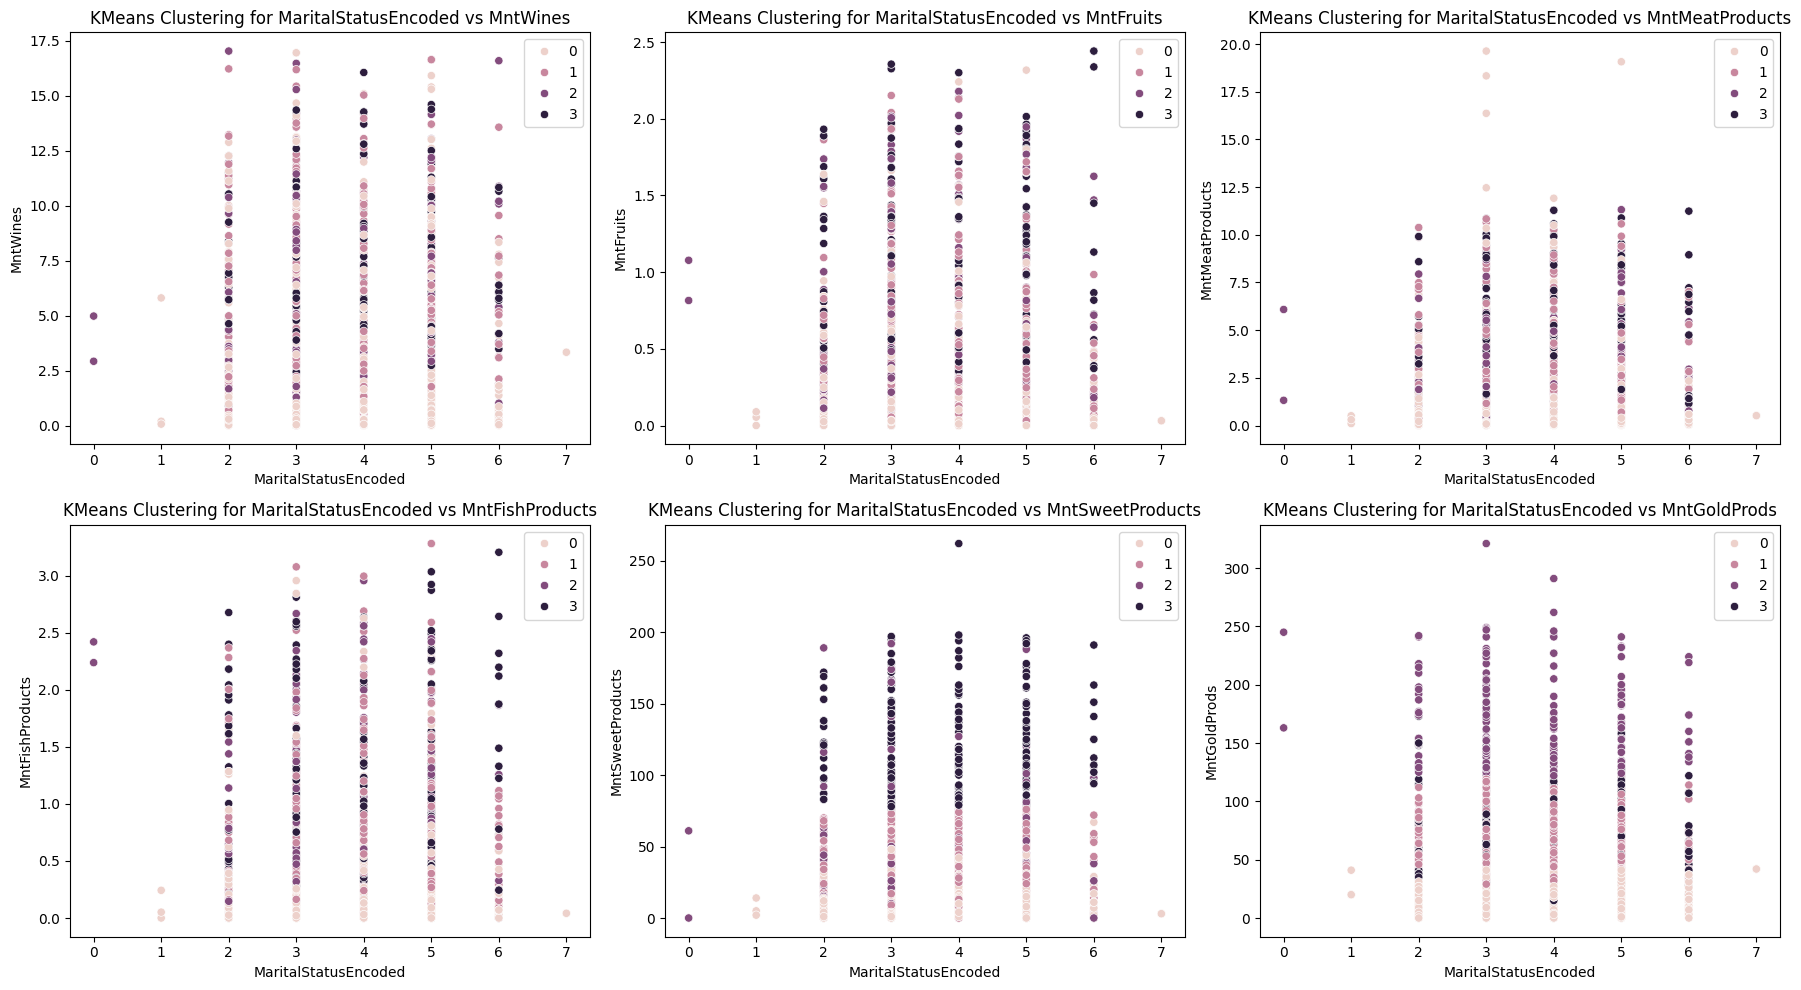

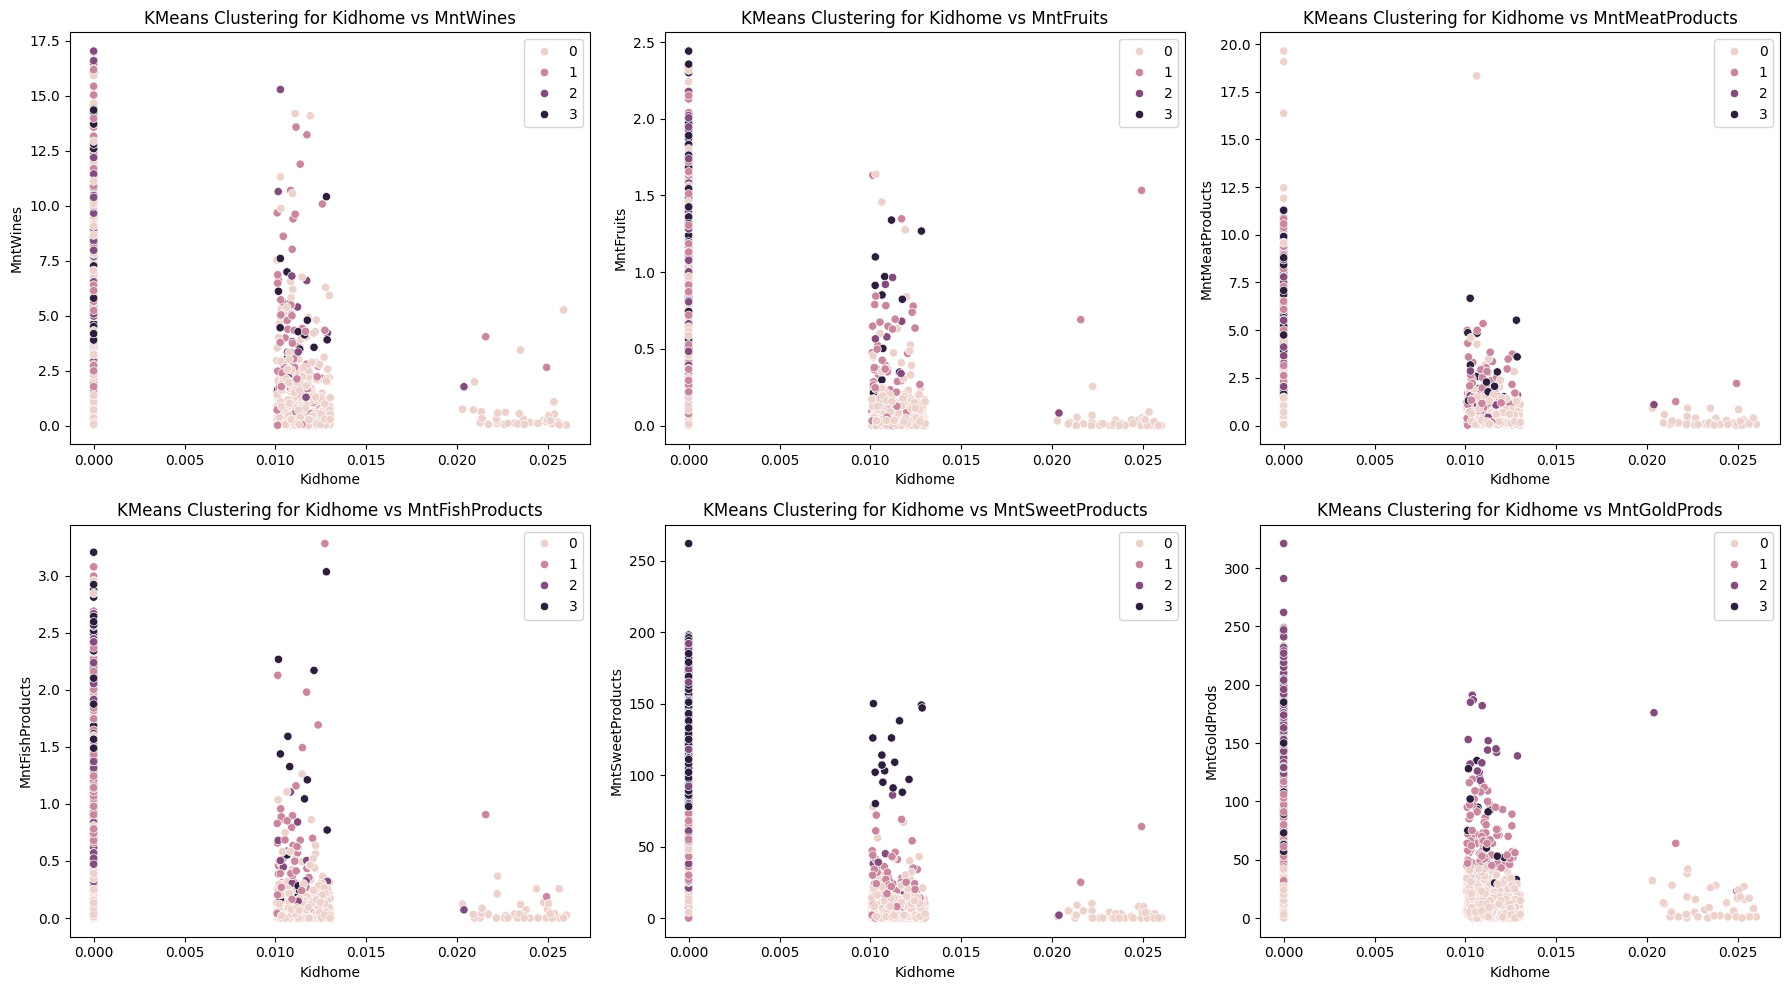

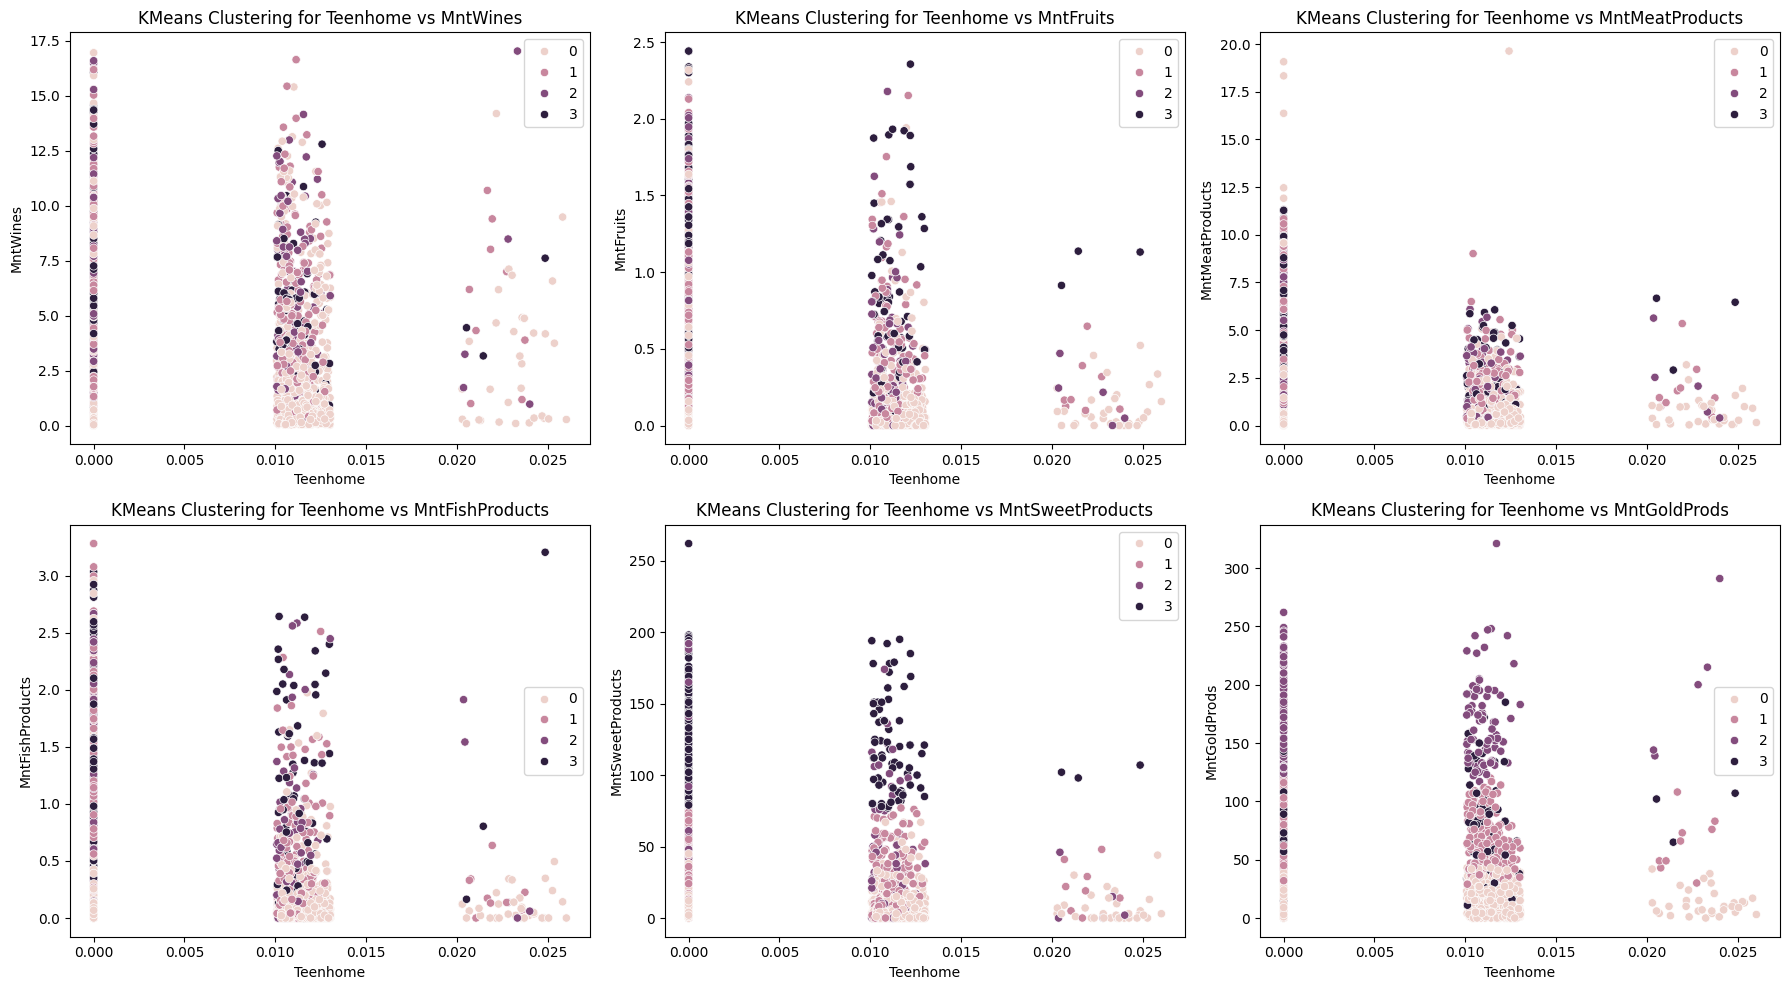

In [ ]:
from sklearn.cluster import KMeans
import seaborn as sb
import matplotlib.pyplot as plt

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

response_variables = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

# Loop through each predictor variable
for predictor_variable in ['MaritalStatusEncoded', 'Kidhome', 'Teenhome']:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Fit KMeans on the predictor variable and response variables
    kmeans.fit(customerdf_numeric[[predictor_variable] + response_variables])
    
    # Loop through each response variable
    for i, response_variable in enumerate(response_variables):
        row = i // 3
        col = i % 3
        sb.scatterplot(data=customerdf_numeric, x=predictor_variable, y=response_variable, hue=kmeans.labels_, ax=axes[row, col])
        axes[row, col].set_title(f'KMeans Clustering for {predictor_variable} vs {response_variable}')
        axes[row, col].set_xlabel(predictor_variable)
        axes[row, col].set_ylabel(response_variable)

    plt.tight_layout()
    plt.show()
